# SIR parameter learning using GD for exact target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1

# Problem setup

Initial conditions:

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-3
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0
# Rates
α = β, γ = 0.03, 0.6
m = 0

In [5]:
ℛ_ₒ = (β * n)/(γ + m)
print(ℛ_ₒ)

10.0


## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$ as the three curves that satisfy the initial conditions for a given pair $\alpha=(\beta,\gamma)$.

In [6]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [7]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [8]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y
ρ̂ = ρ.copy()

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

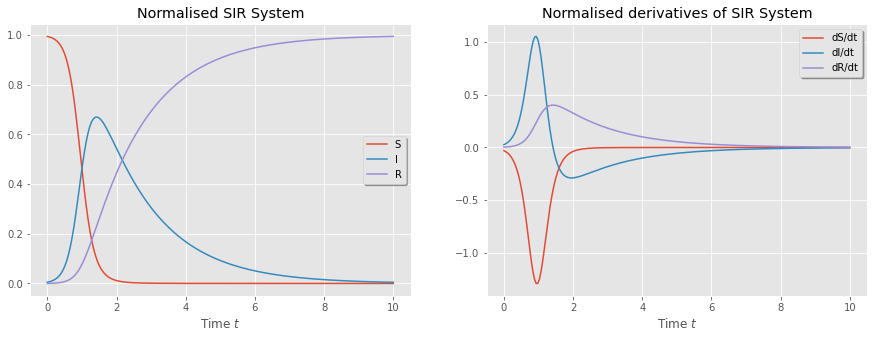

In [9]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [10]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)    # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [11]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 50 function evaluations.


We expect the solution to be zero as $\hat{R} = R$ implies $q = 0$.

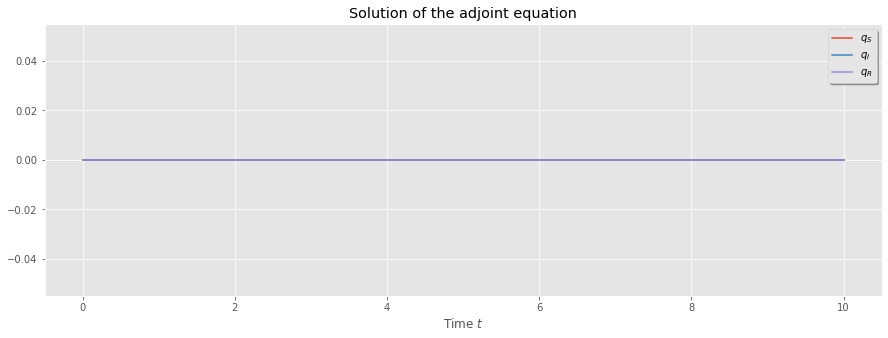

In [12]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t.
\end{align}

In [13]:
def Objective(ρ,ρ̂):    return 0.5 * simpson((ρ-ρ̂)**2,Tₑ).sum()

In [14]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [15]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂) ))

As an example, the distance between ρ and ρ̂ is 0.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t
\end{align}

In [16]:
q = solₛ.y[:,::-1]

In [17]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
display(df.tolist())

[0.0, 0.0]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [18]:
def obj_eval_a(α):                # ** Eval just f ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

In [19]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [20]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.013002574492017794; (β,γ): 0.02686 0.6276


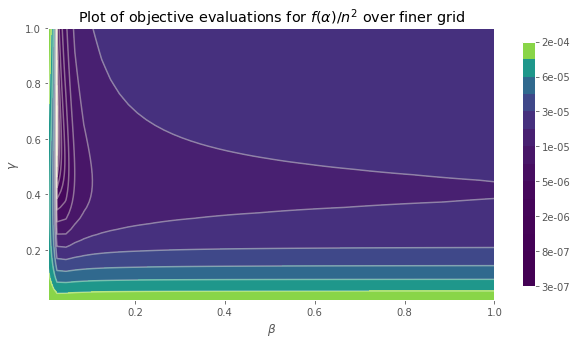

In [21]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

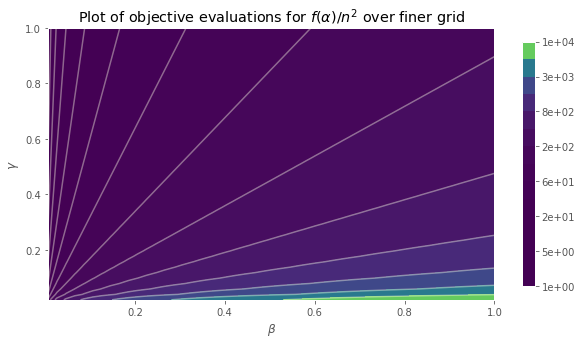

In [22]:
# Contour plot basic reproduction number
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = np.logspace( np.log( Reprod.min() ), np.log( Reprod.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Reprod, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Gradient Descent Algorithm</h2>
<ol>
<li>Let $\alpha_0 \in [0,1]^2$ and $\eta > 0$.</li>
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\alpha_k}$
<li>Compute adjoint $q_{\alpha_k}$
<li>Evaluate the gradient of the reduced functional $d_k := \nabla f(\alpha_k)$
<li>Compute $u = \alpha_{k} - \eta d_k$
<li>If $u \notin [0,1]^2$ or $f(u)> f(\alpha_k)$
<ol>
<li>Backtrack $u$ with respect to $\eta$:</li>
    <ol>
<li> $\eta = \eta \, /\, 10$</li>
<li> Set $u = \mathcal{P}_{[0,1]^2}(\alpha_{k} - \eta d_k)$</li>
<li> Stop whenever $f(u) < f(\alpha_k)$</li>
    </ol>
</ol>
    Else: $\alpha_{k+1} = u$</li>
</ol>
</li>
</ol>
</div>

Let's select a initial point at random:

In [23]:
β, γ = α = rng(0).uniform(0,1,2)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [24]:
def GD_Algorithm(α, iters, save_iter = False, critical = 1, ε = 1e-9):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'df_β':[], 'df_γ':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    β, γ = α
    timed = 0.0
    for k in range(iters):
        it_time = time.time()
        
        # Compute state
        if k == 0:
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                              dense_output=True, vectorized=True)
            if ρ_sol['success'] != True:    print('Should re-evaluate for', β,γ)
            ρ  = ρ_sol.y
            f  = Objective(ρ,ρ̂) 
            f /= (n**2)
        ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,β,γ)), axis=-1)        # Interpolate state 
        
        # Compute adjoint
        q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(β, γ, ρₜ), t_eval = Tₑ[::-1], 
                          dense_output=True, vectorized=True)
        q = q_sol.y[:,::-1]
        
        # Compute derivative
        df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
        df /= (n**2)   # scaling
        
        # Find new step
        for η in 10**-linspace(0,40,41):
            u = proj(α - η*df/norm(df))
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=u, t_eval = Tₑ, dense_output=True, vectorized=True)
            fₖ  = Objective(ρ_sol.y,ρ̂)
            fₖ /= (n**2)
            if fₖ < f :#- 10**4 * η * df.dot(df)/norm(df):
                break
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( f )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(2**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
        # Update step
        v = α.copy()
        α = u
        β, γ = α
        
        if abs(f - fₖ) < 5e-13:
            print('|fₖ - f| < 10^-14')
        
        f = fₖ
        ρ = ρ_sol.y
        
        if norm(α - v)/(2.0**0.5) < ε:
            print('‖αₖ - u‖ < {0:1.0e}'.format(ε))
            print(α)
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    return α, ρ, every_critical, every_iter

In [25]:
ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, 10000, save_iter = True, critical = 50, ε = 1e-7)

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  8.0e-01 |     0.09  | 1.821e+00   |   2.575e+00  
*     50 |  8.2e-04 |     0.97  | 8.122e-02   |   1.025e-01  
*    100 |  7.1e-04 |     1.92  | 8.065e-02   |   1.033e-01  
*    150 |  6.1e-04 |     2.84  | 7.899e-02   |   1.022e-01  
*    200 |  5.3e-04 |     3.74  | 8.055e-02   |   1.059e-01  
*    250 |  4.5e-04 |     4.62  | 8.121e-02   |   1.080e-01  
*    300 |  3.9e-04 |     5.49  | 8.112e-02   |   1.088e-01  
*    350 |  3.3e-04 |     6.33  | 8.093e-02   |   1.094e-01  
*    400 |  2.9e-04 |     7.15  | 8.035e-02   |   1.093e-01  
*    450 |  2.5e-04 |     7.98  | 8.056e-02   |   1.102e-01  
*    500 |  2.1e-04 |     8.79  | 8.063e-02   |   1.108e-01  
*    550 |  1.8e-04 |     9.59  | 8.101e-02   |   1.119e-01  
*    600 |  1.5e-04 |    10.38  | 8.110e-02   |   1.124e-01  
*    650 |  1.3e-04 |    11.15  | 8.154e-02   |   1.134e-01  
*    70

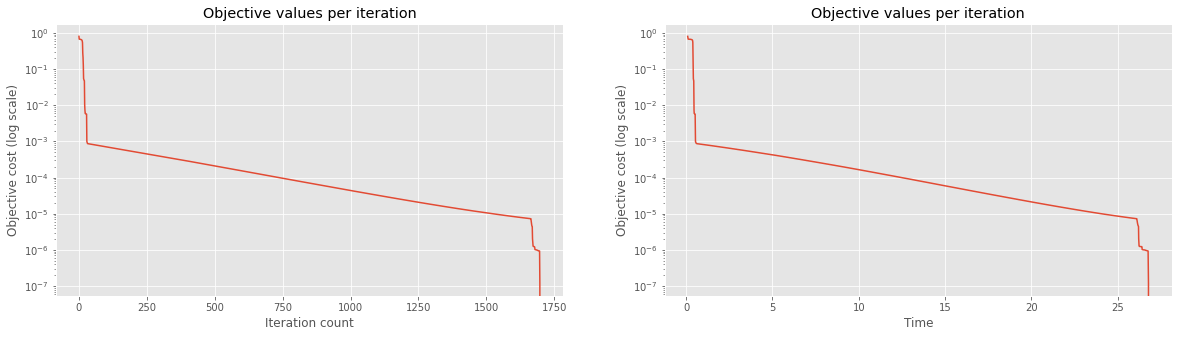

In [26]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']) )
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [27]:
df_critical = pd.DataFrame.from_dict(every_critical)
#df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
#df_critical.to_excel(out_folder+'Critical.xlsx')
#display(df_critical)

# If we want this table in LaTeX format run:
#print(df_critical.to_latex(index=False))

In [28]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
1694,1693,9.338234e-07,26.744332,0.029996,0.600977,0.002715,0.001922,0.002318,0.002352,0.002715,0.001922
1695,1694,9.312506e-07,26.756315,0.029995,0.600976,0.000897,0.001910,0.001404,0.001492,0.001910,0.000897
1696,1695,9.293673e-07,26.766338,0.029994,0.600975,0.000008,0.001902,0.000955,0.001345,0.001902,0.000008
1697,1696,1.183139e-07,26.787221,0.029990,0.599975,-0.023122,-0.000181,0.011652,0.016350,0.023122,0.000181
1698,1697,6.292543e-10,26.809558,0.030000,0.599975,-0.000371,-0.000051,0.000211,0.000265,0.000371,0.000051


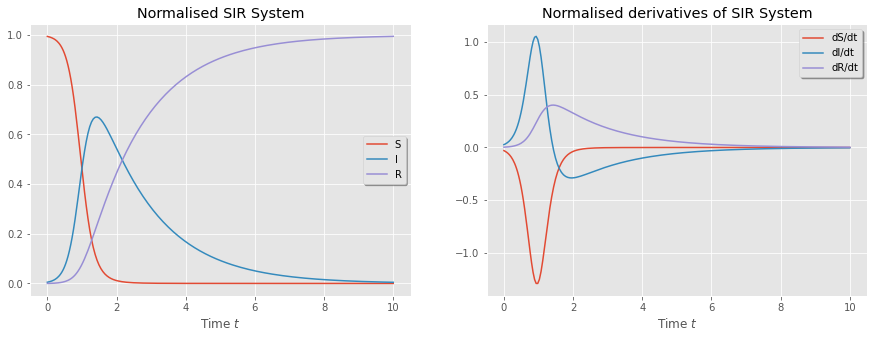

In [29]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, ᾱ[0], ᾱ[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

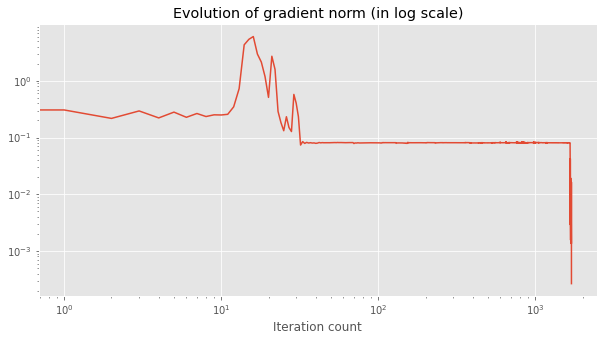

In [30]:
# Evolution of gradient norm
plt.figure(figsize=(10,5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

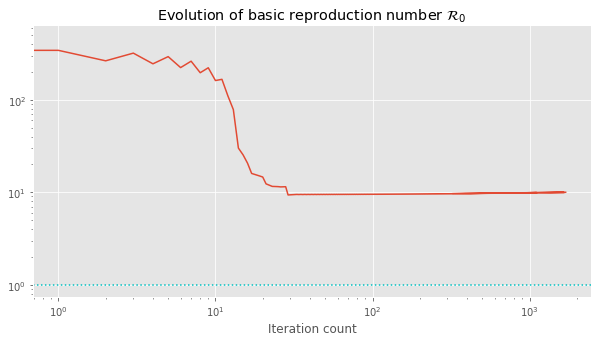

In [31]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

In [32]:
α̂ = df_every['β'][ argmin(df_every['obj']) ], df_every['γ'][ argmin(df_every['obj']) ]

β_its, γ_its = maximum(df_every['β'].to_numpy(), 0.0071), df_every['γ'].to_numpy()

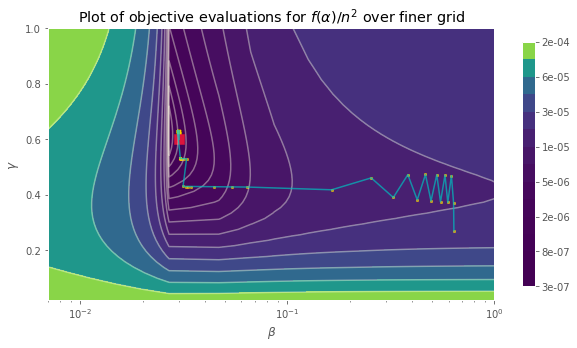

In [33]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

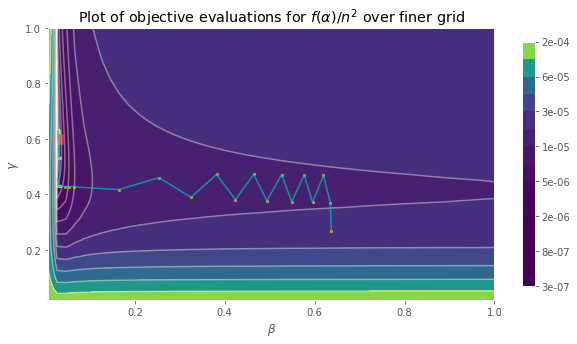

In [34]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

---